<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/SupervisedML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=d13a8e4c5ecf32366b81c3d6037dc0f3ea4eec2d7819cd474bb39da7f7ce0091
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('supervised_ml_classification').getOrCreate()

In [8]:
df = spark.read.csv('sample_data/bank_data.csv', inferSchema=True, header=True)
print((df.count(), len(df.columns)))

(41188, 21)


In [9]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- target_class: string (nullable = true)



In [10]:
df.groupBy('target_class').count().show()

+------------+-----+
|target_class|count|
+------------+-----+
|          no|36548|
|         yes| 4640|
+------------+-----+



## Deleting rows to reduce data size and no of columns

In [12]:
# Calculate the fraction to keep 'no' records such that 30,000 'no' records are dropped
total_no_records = 36548
records_to_keep = total_no_records - 30000
fraction_to_keep = records_to_keep / total_no_records

# Define the fractions dictionary for sampling
fractions = {'no': fraction_to_keep, 'yes': 1.0}

# Sample the DataFrame based on the fractions
sampled_df = df.sampleBy("target_class", fractions, seed=42)

# Now select the columns you want to keep
columns_to_keep = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'target_class']
new_df = sampled_df.select(columns_to_keep)

# Show the result to verify
new_df.show(5)

# Optionally, check the count of 'no' and 'yes' in the new DataFrame
new_df.groupBy('target_class').count().show()

+---+-----------+-------+-----------+-------+-------+----+------------+
|age|        job|marital|  education|default|housing|loan|target_class|
+---+-----------+-------+-----------+-------+-------+----+------------+
| 41|blue-collar|married|    unknown|unknown|     no|  no|          no|
| 35|blue-collar|married|   basic.6y|     no|    yes|  no|          no|
| 50|blue-collar|married|   basic.9y|     no|    yes| yes|          no|
| 59| technician|married|    unknown|     no|    yes|  no|          no|
| 34|   services|married|high.school|     no|     no|  no|          no|
+---+-----------+-------+-----------+-------+-------+----+------------+
only showing top 5 rows

+------------+-----+
|target_class|count|
+------------+-----+
|          no| 6573|
|         yes| 4640|
+------------+-----+



## Feature Engineering for Model

In [15]:
from pyspark.sql import functions as F
from pyspark.sql import *
new_df = new_df.withColumn("label", F.when(new_df.target_class=='no', F.lit(0)).otherwise(F.lit(1)))
new_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 4640|
|    0| 6573|
+-----+-----+



In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

def cat_to_num(df):
    for col in df.columns:
        # Create a StringIndexer
        stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_index")
        model = stringIndexer.fit(df)
        indexed = model.transform(df)

        # Create a OneHotEncoder
        encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec")
        # Fit and transform using OneHotEncoder
        model = encoder.fit(indexed)
        df = model.transform(indexed)

    # Assemble the encoded categorical columns along with numerical columns to create a features column
    df_assembler = VectorAssembler(inputCols=['age', 'marital_vec', 'education_vec', 'default_vec', 'housing_vec', 'loan_vec'], outputCol="features")
    df = df_assembler.transform(df)

    return df.select(['features', 'label'])

df_new = cat_to_num(new_df)

In [17]:
df_new.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,10,12,14...|    0|
|(17,[0,1,9,11,13,...|    0|
|(17,[0,1,6,11,13,...|    0|
|(17,[0,1,10,11,13...|    0|
|(17,[0,1,5,11,14,...|    0|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,1,5,11,14,...|    0|
|(17,[0,1,7,12,13,...|    0|
|(17,[0,1,9,12,14,...|    0|
|(17,[0,1,4,11,14,...|    0|
|(17,[0,2,6,11,13,...|    0|
|(17,[0,1,10,11,13...|    0|
|(17,[0,1,4,12,13,...|    0|
|(17,[0,3,8,12,13,...|    1|
|(17,[0,1,6,12,14,...|    0|
|(17,[0,1,4,12,13,...|    1|
|(17,[0,1,6,11,14,...|    1|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,3,4,11,14,...|    0|
+--------------------+-----+
only showing top 20 rows



## Split the Data into Train and Test Datasets

In [18]:
train, test = df_new.randomSplit([0.75,0.25])
print(f"Size of train Dataset : {train.count()}")
print(f"Size of test Dataset : {test.count()}")

Size of train Dataset : 8354
Size of test Dataset : 2859


## Build and Train the Logistic Regression model

In [19]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(train)
print(lr_model.coefficients)

[0.019229680583733748,-0.7252285299107761,-0.2890253196870109,-0.7840907981597982,0.04657511938269839,-0.19979179980244466,-0.5082521497983223,-0.10037684783730606,-0.08028087455734703,-0.30033444063413156,0.1658880298133049,9.617381463998484,8.702987374597917,0.07358978401933576,0.07022905146082366,0.17034804150548247,0.09014711859589636]


## Evaluate Performance on Training Data

In [21]:
lr_summary = lr_model.summary
print(f"{lr_summary.accuracy}")
print(f"{lr_summary.areaUnderROC}")
print(f"{lr_summary.weightedRecall}")
print(f"{lr_summary.weightedPrecision}")

0.6091692602346181
0.6255654333165382
0.6091692602346181
0.5942856462708686


In [22]:
lr_summary.precisionByThreshold.show()

+------------------+------------------+
|         threshold|         precision|
+------------------+------------------+
|0.7215116362676368|               1.0|
| 0.704885731377001|              0.75|
|0.7034833849335207|0.6666666666666666|
|0.6920269658501402|             0.625|
|0.6837703302183755|               0.6|
|0.6809200275318057|0.5833333333333334|
|0.6788654862288304|0.6428571428571429|
|0.6687565508219957|             0.625|
|0.6648580088694964| 0.631578947368421|
|0.6596768965174618|0.6818181818181818|
|0.6589219966131411|0.7083333333333334|
|0.6557242331145414|0.7037037037037037|
|0.6553466071143983|0.7241379310344828|
|0.6511207935746719|0.7096774193548387|
|0.6496078436364057|0.7428571428571429|
|0.6488424980271214|0.6923076923076923|
|0.6461185511068811|0.6829268292682927|
|0.6444486533015403|0.6590909090909091|
|0.6437125702634077|0.6739130434782609|
| 0.642082749124431|            0.6875|
+------------------+------------------+
only showing top 20 rows



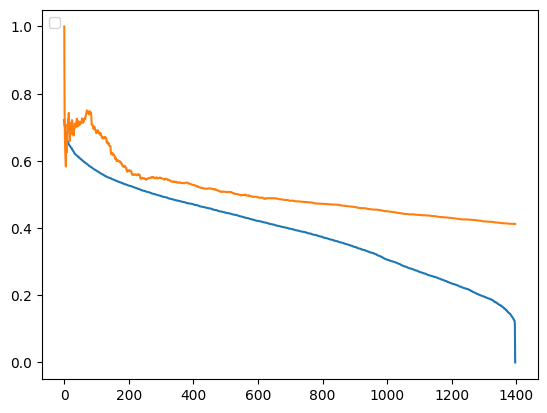

In [33]:
import matplotlib.pyplot as plt

# Assuming lr_summary is a BinaryClassificationMetrics object

# Get the precision by threshold DataFrame
precision_by_threshold = lr_summary.precisionByThreshold

# Collect the DataFrame to the driver
precision_by_threshold_list = precision_by_threshold.collect()

# Extract threshold and precision values
thresholds = [row['threshold'] for row in precision_by_threshold_list]
precisions = [row['precision'] for row in precision_by_threshold_list]

# Now use matplotlib to plot the precision against threshold
plt.plot(precision_by_threshold_list)
plt.legend(loc='upper left')
plt.show()


## **Different Graphs**
* From the ROC Curve, a curve close to the top-left corner indicates a better performance.
* From the Precision-Recall Curve, a higher area under the curve (AUC) indicates that the classifier is returning more true positives and fewer false negatives.
* The Threshold vs. Metrics Plot will show you how the balance between precision and recall changes as you adjust the threshold. The optimal point often maximizes the F-Measure, which balances precision and recall.
* The Confusion Matrix is a direct way to see the actual versus predicted counts of the classes.
* For a Calibration Curve, if the plot significantly deviates from the diagonal, it indicates that the predicted probabilities are not representative of the actual outcomes.

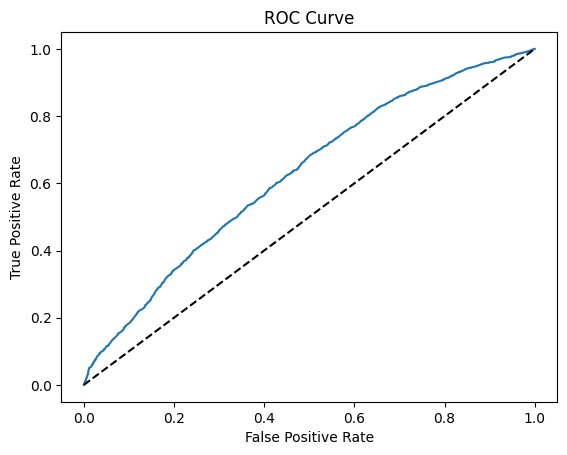

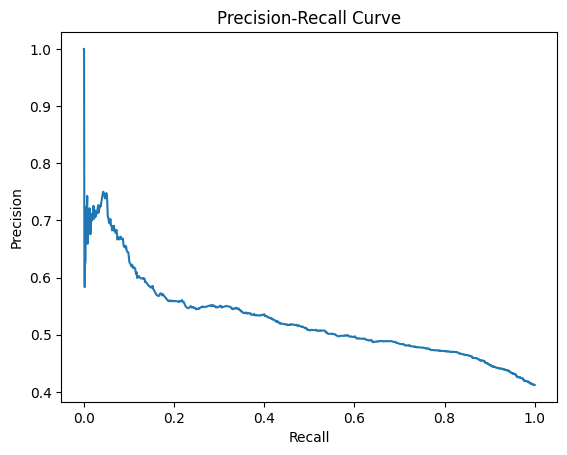

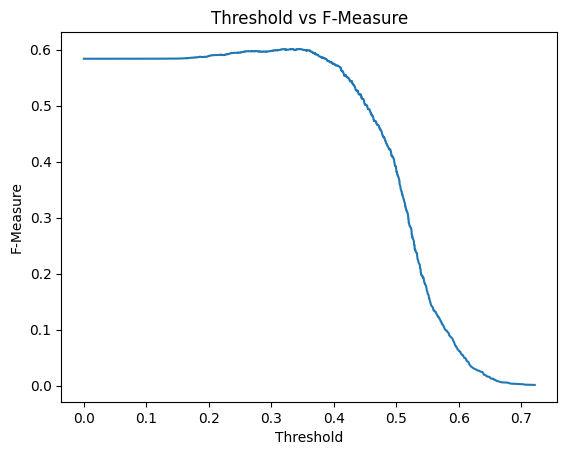

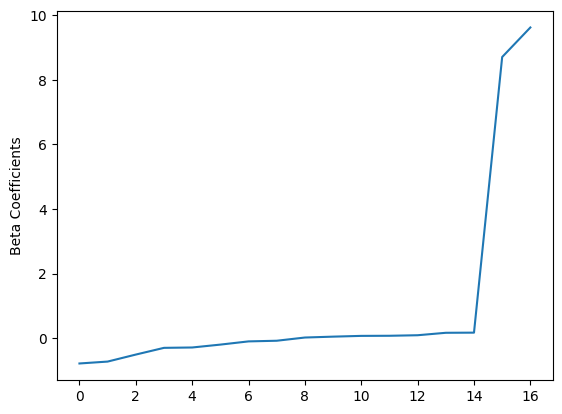

In [38]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Assuming predictions is a DataFrame with the logistic regression model's predictions
# It needs to have a column with the label and a column with the prediction

# ROC Curve
roc = lr_summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision-Recall Curve
pr = lr_summary.pr.toPandas()
plt.figure()
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Threshold vs. Metrics Plot
f_measure = lr_summary.fMeasureByThreshold.toPandas()
plt.figure()
plt.plot(f_measure['threshold'], f_measure['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-Measure')
plt.title('Threshold vs F-Measure')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
plt.show()


In [23]:
lr_summary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|5.807200929152149E-4|
|2.036659877800407...|8.710801393728223E-4|
|4.073319755600815E-4|0.001161440185830...|
|6.109979633401223E-4|0.001451800232288...|
| 8.14663951120163E-4|0.001742160278745...|
|0.001018329938900...|0.002032520325203...|
|0.001018329938900...|0.002613240418118467|
|0.001221995926680...|0.002903600464576...|
|0.001425661914460...|0.003484320557491289|
|0.001425661914460...|0.004355400696864111|
|0.001425661914460...|0.004936120789779327|
|0.001629327902240326|0.005516840882694541|
|0.001629327902240326|0.006097560975609756|
|0.001832993890020...|0.006387921022067364|
|0.001832993890020...|0.007549361207897794|
|0.002443991853360489|  0.0078397212543554|
|0.002647657841140...|0.008130081300813009|
|0.003054989816700611|0.008420441347270616|
|0.003054989816700611|0.00900116

In [24]:
lr_summary.recallByThreshold.show()

+------------------+--------------------+
|         threshold|              recall|
+------------------+--------------------+
|0.7215116362676368|5.807200929152149E-4|
| 0.704885731377001|8.710801393728223E-4|
|0.7034833849335207|0.001161440185830...|
|0.6920269658501402|0.001451800232288...|
|0.6837703302183755|0.001742160278745...|
|0.6809200275318057|0.002032520325203...|
|0.6788654862288304|0.002613240418118467|
|0.6687565508219957|0.002903600464576...|
|0.6648580088694964|0.003484320557491289|
|0.6596768965174618|0.004355400696864111|
|0.6589219966131411|0.004936120789779327|
|0.6557242331145414|0.005516840882694541|
|0.6553466071143983|0.006097560975609756|
|0.6511207935746719|0.006387921022067364|
|0.6496078436364057|0.007549361207897794|
|0.6488424980271214|  0.0078397212543554|
|0.6461185511068811|0.008130081300813009|
|0.6444486533015403|0.008420441347270616|
|0.6437125702634077|0.009001161440185831|
| 0.642082749124431|0.009581881533101045|
+------------------+--------------

In [25]:
lr_summary.pr.show()

+--------------------+------------------+
|              recall|         precision|
+--------------------+------------------+
|                 0.0|               1.0|
|5.807200929152149E-4|               1.0|
|8.710801393728223E-4|              0.75|
|0.001161440185830...|0.6666666666666666|
|0.001451800232288...|             0.625|
|0.001742160278745...|               0.6|
|0.002032520325203...|0.5833333333333334|
|0.002613240418118467|0.6428571428571429|
|0.002903600464576...|             0.625|
|0.003484320557491289| 0.631578947368421|
|0.004355400696864111|0.6818181818181818|
|0.004936120789779327|0.7083333333333334|
|0.005516840882694541|0.7037037037037037|
|0.006097560975609756|0.7241379310344828|
|0.006387921022067364|0.7096774193548387|
|0.007549361207897794|0.7428571428571429|
|  0.0078397212543554|0.6923076923076923|
|0.008130081300813009|0.6829268292682927|
|0.008420441347270616|0.6590909090909091|
|0.009001161440185831|0.6739130434782609|
+--------------------+------------

## Evaluate Performance on test data

In [26]:
model_predictions = lr_model.transform(test)
model_predictions.columns

['features', 'label', 'rawPrediction', 'probability', 'prediction']

In [27]:
model_predictions.select(['label', 'probability', 'prediction']).show(10, False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|1    |[0.6370994281613863,0.3629005718386137] |0.0       |
|0    |[0.6326418394308743,0.36735816056912574]|0.0       |
|0    |[0.6191349430008287,0.3808650569991713] |0.0       |
|0    |[0.6054411540543257,0.39455884594567425]|0.0       |
|0    |[0.6054411540543257,0.39455884594567425]|0.0       |
|1    |[0.568160910978172,0.431839089021828]   |0.0       |
|1    |[0.544433282941768,0.45556671705823204] |0.0       |
|1    |[0.6114631751351135,0.3885368248648865] |0.0       |
|1    |[0.6068849934943771,0.3931150065056229] |0.0       |
|1    |[0.6068849934943771,0.3931150065056229] |0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [39]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [40]:
# RMSE value of the model on test data
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_auroc = lr_evaluator.evaluate(model_predictions)
print(f'The auc value of Logistic Regression Model is {lr_auroc}')


# RMSE value of the model on test data
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
lr_aupr = lr_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {lr_aupr}')

The auc value of Logistic Regression Model is 0.6235479761160165
The aupr value of Logistic Regression Model is 0.5288149463411007


In [41]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()


In [42]:
#Recall
float(true_pos)/(actual_pos)

0.2959866220735786

In [43]:
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()
#Precision
float(true_pos)/(pred_pos)

0.5471406491499228

## **Decision Tree Classifier**

In [44]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_model = dt.fit(train)

In [45]:
model_predictions = dt_model.transform(test)

In [46]:
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+---------------------------------------+----------+
|label|probability                            |prediction|
+-----+---------------------------------------+----------+
|1    |[0.5989198919891989,0.4010801080108011]|0.0       |
|0    |[0.5989198919891989,0.4010801080108011]|0.0       |
|0    |[0.5989198919891989,0.4010801080108011]|0.0       |
|0    |[0.5989198919891989,0.4010801080108011]|0.0       |
|0    |[0.5989198919891989,0.4010801080108011]|0.0       |
|1    |[0.5989198919891989,0.4010801080108011]|0.0       |
|1    |[0.5989198919891989,0.4010801080108011]|0.0       |
|1    |[0.4523809523809524,0.5476190476190477]|1.0       |
|1    |[0.4523809523809524,0.5476190476190477]|1.0       |
|1    |[0.4523809523809524,0.5476190476190477]|1.0       |
+-----+---------------------------------------+----------+
only showing top 10 rows



In [47]:
# RMSE value of the model on test data
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
dt_auroc = dt_evaluator.evaluate(model_predictions)
print(f'The auc value of Decision Tree Classifier Model is {dt_auroc}')


# RMSE value of the model on test data
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
dt_aupr = dt_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {dt_aupr}')

The auc value of Decision Tree Classifier Model is 0.48740087724767056
The aupr value of Logistic Regression Model is 0.411070153070734


In [48]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [49]:
#Recall
float(true_pos)/(actual_pos)


0.2525083612040134

In [50]:
#Precision on test Data
float(true_pos)/(pred_pos)

0.6974595842956121

## **Support Vector Machines**

## Build and train SVM model

In [51]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=50,maxDepth=30)
rf_model = rf.fit(train)

In [52]:
model_predictions = rf_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|1    |[0.586106905622406,0.41389309437759403] |0.0       |
|0    |[0.6134878580033584,0.3865121419966417] |0.0       |
|0    |[0.4952820545318737,0.5047179454681263] |1.0       |
|0    |[0.5436095360928301,0.45639046390716986]|0.0       |
|0    |[0.5436095360928301,0.45639046390716986]|0.0       |
|1    |[0.5263411698856911,0.47365883011430887]|0.0       |
|1    |[0.41636188190438594,0.583638118095614] |1.0       |
|1    |[0.6162967249913978,0.38370327500860213]|0.0       |
|1    |[0.6162967249913978,0.38370327500860213]|0.0       |
|1    |[0.6162967249913978,0.38370327500860213]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



## Evaluate performance on test data

In [53]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(model_predictions)
print(f'The auc value of RandomForestClassifier Model is {rf_auroc}')

rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(model_predictions)
print(f'The aupr value of RandomForestClassifier Model is {rf_aupr}')


The auc value of RandomForestClassifier Model is 0.6591084834797091
The aupr value of RandomForestClassifier Model is 0.5842001405747794


In [54]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()


In [55]:
#Recall
float(true_pos)/(actual_pos)

0.28762541806020064

In [56]:
#Precision on test Data
float(true_pos)/(pred_pos)


0.6335174953959485